In [1]:
import requests
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
def get_API_data(filters, structure):
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"
    # pack parameters
    api_params = {
        "filters": str.join(";", filters),
        "structure": json.dumps(structure, separators=(",", ":")),
        "page":1
        }
    response = requests.get(endpoint, params=api_params, timeout = 50)  # send request
    
    # running into problem when status_code >=400
    if response.status_code >= 400:
        raise RuntimeError(f'Request failed: { response.text }')
        
    result = response.json()
    return result['data']

In [3]:
query_filters = ['areaType=region','areaName=London']
# the data we require
query_structure = {
    "date": "date",
    "name": "areaName",
    "daily_cases": "newCasesBySpecimenDate",
    "daily_cases_age": "newCasesBySpecimenDateAgeDemographics",
    "cumulative_cases": "cumCasesBySpecimenDate",
    "daily_deaths": "newDeaths28DaysByPublishDate",
    "daily_deaths_age": "newDeaths28DaysByDeathDateAgeDemographics",
    "cumulative_deaths": "cumDeaths28DaysByPublishDate",
    "cumulative_vaccinated": "cumPeopleVaccinatedSecondDoseByVaccinationDate",
    "vaccination_age": "vaccinationsAgeDemographics"
}
# get national data
results_json = get_API_data(query_filters, query_structure)

In [4]:
london_covid = pd.json_normalize(results_json)
london_covid.dropna(inplace=True)
london_covid

,date,name,daily_cases,daily_cases_age,cumulative_cases,daily_deaths,daily_deaths_age,cumulative_deaths,cumulative_vaccinated,vaccination_age
1,2022-04-04,London,2928.0,[],2810603.0,11.0,[],19188.0,5998364.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
2,2022-04-03,London,3570.0,[],2807675.0,0.0,[],19177.0,5996873.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
3,2022-04-02,London,3614.0,[],2804105.0,0.0,[],19177.0,5996068.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
4,2022-04-01,London,4937.0,[],2800491.0,11.0,[],19177.0,5993754.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
5,2022-03-31,London,5691.0,"[{'age': '00_04', 'cases': 115, 'rollingSum': ...",2795554.0,5.0,"[{'age': '00_04', 'deaths': 0, 'rollingSum': 0...",19166.0,5991768.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
...,...,...,...,...,...,...,...,...,...,...
479,2020-12-12,London,4749.0,"[{'age': '00_04', 'cases': 137, 'rollingSum': ...",211609.0,28.0,"[{'age': '00_04', 'deaths': 0, 'rollingSum': 0...",7424.0,1350.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
480,2020-12-11,London,5538.0,"[{'age': '00_04', 'cases': 151, 'rollingSum': ...",206860.0,34.0,"[{'age': '00_04', 'deaths': 0, 'rollingSum': 0...",7396.0,1350.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
481,2020-12-10,London,5080.0,"[{'age': '00_04', 'cases': 140, 'rollingSum': ...",201322.0,40.0,"[{'age': '00_04', 'deaths': 0, 'rollingSum': 0...",7362.0,1350.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
482,2020-12-09,London,4462.0,"[{'age': '00_04', 'cases': 119, 'rollingSum': ...",196242.0,35.0,"[{'age': '00_04', 'deaths': 0, 'rollingSum': 0...",7322.0,1341.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."


In [5]:
cases_age = london_covid[['date', 'daily_cases_age']]
cases_age = cases_age.explode('daily_cases_age')
cases_age_split = cases_age['daily_cases_age'].apply(pd.Series)
cases_age_split.columns

Index([0, 'age', 'cases', 'rollingSum', 'rollingRate'], dtype='object')

In [6]:
cols = [cases_age['date'], cases_age_split['age'], cases_age_split['cases'], cases_age_split['rollingRate'], cases_age_split['rollingSum']]
cases_age = pd.concat(cols, axis=1)
cases_age.dropna(inplace=True)
cases_age

,date,age,cases,rollingRate,rollingSum
5,2022-03-31,00_04,115.0,165.2,984.0
5,2022-03-31,00_59,4651.0,570.9,42810.0
5,2022-03-31,05_09,150.0,233.0,1413.0
5,2022-03-31,10_14,175.0,332.5,1831.0
5,2022-03-31,15_19,191.0,397.5,1886.0
...,...,...,...,...,...
483,2020-12-08,70_74,50.0,110.9,311.0
483,2020-12-08,75_79,41.0,116.1,228.0
483,2020-12-08,80_84,39.0,135.1,204.0
483,2020-12-08,85_89,23.0,166.3,156.0


In [7]:
deaths_age = london_covid[['date', 'daily_deaths_age']]
deaths_age = deaths_age.explode('daily_deaths_age')
deaths_age_split = deaths_age['daily_deaths_age'].apply(pd.Series)
deaths_age_split.columns

Index([0, 'age', 'deaths', 'rollingSum', 'rollingRate'], dtype='object')

In [8]:
cols = [deaths_age['date'], deaths_age_split['age'], deaths_age_split['deaths'], deaths_age_split['rollingRate'], deaths_age_split['rollingSum']]
deaths_age = pd.concat(cols, axis=1)
deaths_age.dropna(inplace=True)
deaths_age

,date,age,deaths,rollingRate,rollingSum
5,2022-03-31,00_04,0.0,0.0,0.0
5,2022-03-31,00_59,1.0,0.1,6.0
5,2022-03-31,05_09,0.0,0.0,0.0
5,2022-03-31,10_14,0.0,0.0,0.0
5,2022-03-31,15_19,0.0,0.0,0.0
...,...,...,...,...,...
483,2020-12-08,70_74,0.0,7.1,20.0
483,2020-12-08,75_79,4.0,17.8,35.0
483,2020-12-08,80_84,7.0,21.9,33.0
483,2020-12-08,85_89,9.0,45.8,43.0


In [9]:
vac_age = london_covid[['date', 'vaccination_age']]
vac_age = vac_age.explode('vaccination_age')
vac_age_split = vac_age['vaccination_age'].apply(pd.Series)
vac_age_split.columns

Index(['age', 'VaccineRegisterPopulationByVaccinationDate',
       'cumPeopleVaccinatedCompleteByVaccinationDate',
       'newPeopleVaccinatedCompleteByVaccinationDate',
       'cumPeopleVaccinatedFirstDoseByVaccinationDate',
       'newPeopleVaccinatedFirstDoseByVaccinationDate',
       'cumPeopleVaccinatedSecondDoseByVaccinationDate',
       'newPeopleVaccinatedSecondDoseByVaccinationDate',
       'cumPeopleVaccinatedThirdInjectionByVaccinationDate',
       'newPeopleVaccinatedThirdInjectionByVaccinationDate',
       'cumVaccinationFirstDoseUptakeByVaccinationDatePercentage',
       'cumVaccinationCompleteCoverageByVaccinationDatePercentage',
       'cumVaccinationSecondDoseUptakeByVaccinationDatePercentage',
       'cumVaccinationThirdInjectionUptakeByVaccinationDatePercentage'],
      dtype='object')

In [10]:
cols = [
            vac_age['date'],
            vac_age_split['age'],
            vac_age_split['cumVaccinationFirstDoseUptakeByVaccinationDatePercentage'],
            vac_age_split['cumVaccinationCompleteCoverageByVaccinationDatePercentage'],
            vac_age_split['cumVaccinationSecondDoseUptakeByVaccinationDatePercentage']
]
# concat these columns together
vac_age = pd.concat(cols, axis=1)
vac_age

,date,age,cumVaccinationFirstDoseUptakeByVaccinationDatePercentage,cumVaccinationCompleteCoverageByVaccinationDatePercentage,cumVaccinationSecondDoseUptakeByVaccinationDatePercentage
1,2022-04-04,12_15,44.2,24.8,24.8
1,2022-04-04,16_17,54.8,40.3,40.3
1,2022-04-04,18_24,63.2,54.6,54.6
1,2022-04-04,25_29,65.0,59.9,59.9
1,2022-04-04,30_34,62.9,58.8,58.8
...,...,...,...,...,...
483,2020-12-08,70_74,0.0,0.0,0.0
483,2020-12-08,75_79,0.0,0.0,0.0
483,2020-12-08,80_84,0.1,0.0,0.0
483,2020-12-08,85_89,0.1,0.0,0.0


<AxesSubplot:title={'center':'Cumlative Percentage of 1st Dose Vaccination By Age Group'}, xlabel='date'>

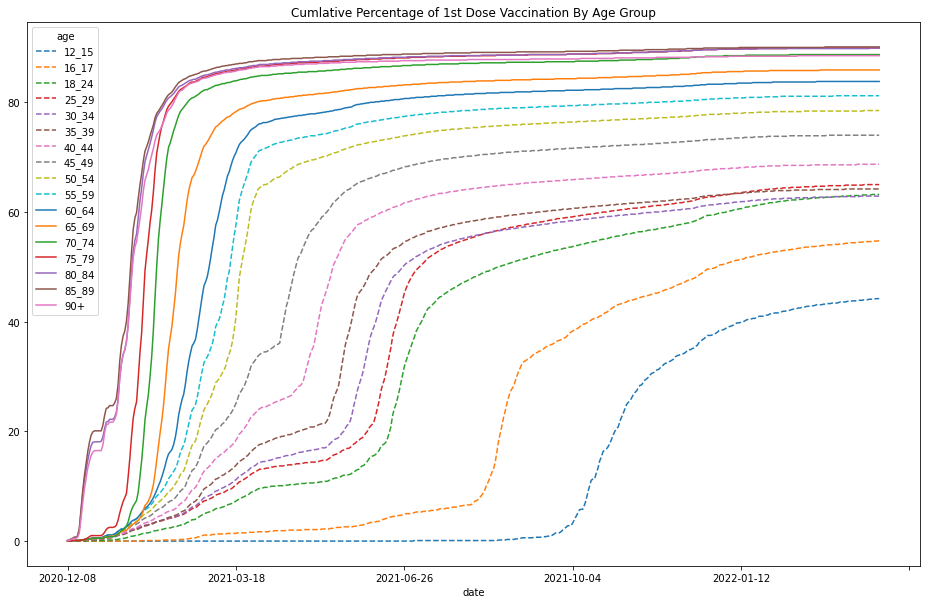

In [11]:
table = pd.pivot_table(vac_age, values='cumVaccinationFirstDoseUptakeByVaccinationDatePercentage', index='date', columns='age')
table.plot(style=['--' for _ in range(10)], figsize=(16,10), title='Cumlative Percentage of 1st Dose Vaccination By Age Group')

In [12]:
cases_age.reset_index(inplace=True)
idx = cases_age.loc[(cases_age['age']=='00_59') | (cases_age['age']=='60+')].index
cases_age_md = cases_age.drop(index=idx)
cases_age_md

,index,date,age,cases,rollingRate,rollingSum
0,5,2022-03-31,00_04,115.0,165.2,984.0
2,5,2022-03-31,05_09,150.0,233.0,1413.0
3,5,2022-03-31,10_14,175.0,332.5,1831.0
4,5,2022-03-31,15_19,191.0,397.5,1886.0
5,5,2022-03-31,20_24,358.0,588.9,3278.0
...,...,...,...,...,...,...
10054,483,2020-12-08,70_74,50.0,110.9,311.0
10055,483,2020-12-08,75_79,41.0,116.1,228.0
10056,483,2020-12-08,80_84,39.0,135.1,204.0
10057,483,2020-12-08,85_89,23.0,166.3,156.0


<AxesSubplot:xlabel='date'>

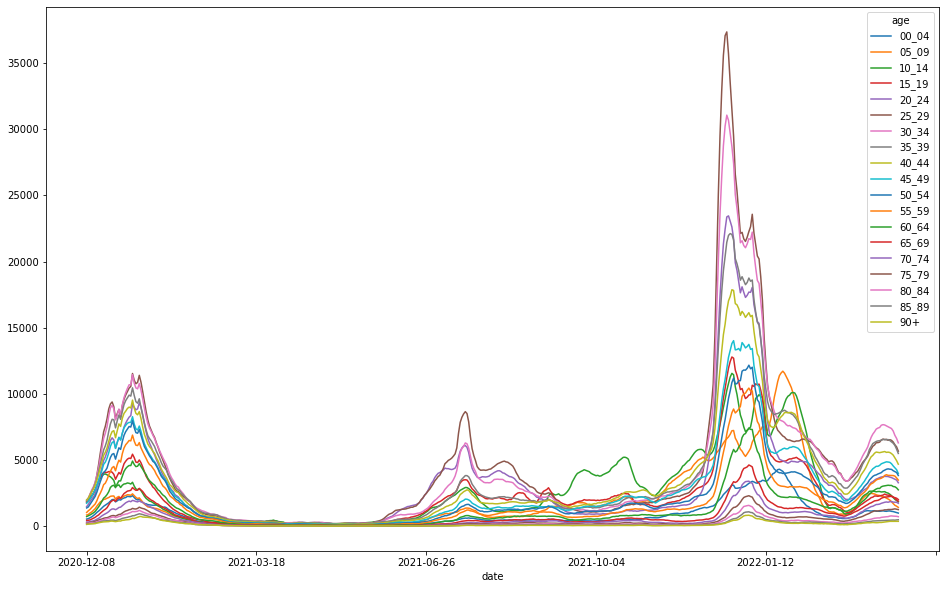

In [13]:
table = pd.pivot_table(cases_age_md, values='rollingSum', index='date', columns='age')
table.plot(figsize=(16,10))

In [14]:
deaths_age.reset_index(inplace=True)
idx = deaths_age.loc[(deaths_age['age']=='00_59') | (deaths_age['age']=='60+')].index
deaths_age_md = deaths_age.drop(index=idx)
deaths_age_md

,index,date,age,deaths,rollingRate,rollingSum
0,5,2022-03-31,00_04,0.0,0.0,0.0
2,5,2022-03-31,05_09,0.0,0.0,0.0
3,5,2022-03-31,10_14,0.0,0.0,0.0
4,5,2022-03-31,15_19,0.0,0.0,0.0
5,5,2022-03-31,20_24,0.0,0.0,0.0
...,...,...,...,...,...,...
10054,483,2020-12-08,70_74,0.0,7.1,20.0
10055,483,2020-12-08,75_79,4.0,17.8,35.0
10056,483,2020-12-08,80_84,7.0,21.9,33.0
10057,483,2020-12-08,85_89,9.0,45.8,43.0


<AxesSubplot:xlabel='date'>

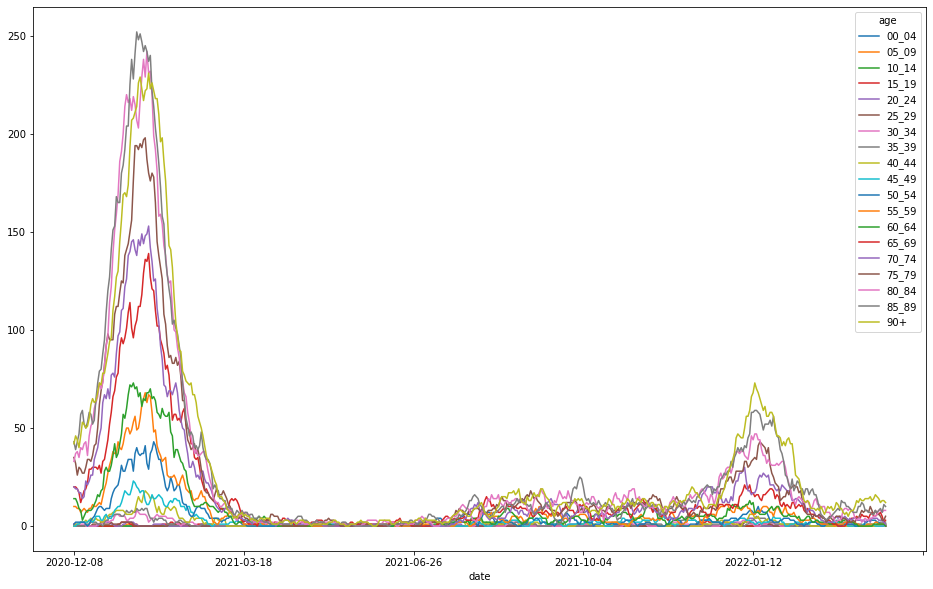

In [15]:
table = pd.pivot_table(deaths_age_md, values='rollingSum', index='date', columns='age')
table.plot(figsize=(16,10))

In [36]:
# Regression 1: Impact of reducing mask mandate
london_covid['date'] = pd.to_datetime(london_covid['date'])
#london_covid.set_index('date', inplace=True)
reg1_startdate = pd.to_datetime('2022-01-01')
data_reg1_y = london_covid[london_covid['date'] > reg1_startdate]
data_reg1_X = pd.read_csv("data/policies/eng-scot.csv", parse_dates=True)
data_reg1_X = data_reg1_X[data_reg1_X['RegionName'] == 'England']
data_reg1_X['H6_Flag'] = data_reg1_X['H6_Flag'].fillna(0)
data_reg1_X['Date'] = pd.to_datetime(data_reg1_X['Date'], format='%Y%m%d')
data_reg1_X = data_reg1_X[data_reg1_X['Date'] > reg1_startdate]
#data_reg1_X = london_covid[london_covid['date'] > pd.to_datetime('2021-01-01')]['daily_cases']
data_reg1_X['T'] = (data_reg1_X['Date'] - reg1_startdate).dt.days
data_reg1 = pd.merge(data_reg1_y, data_reg1_X, left_on='date', right_on='Date')
reg1 = smf.glm(formula='daily_deaths ~ T*H6_Flag', data=data_reg1, family=sm.families.Poisson())
res_reg1 = reg1.fit()
print(res_reg1.summary())
#data_reg1_y['daily_deaths'].plot()
#data_reg1_X.plot()
#data_reg1_X['T'].plot()

                 Generalized Linear Model Regression Results                  
Dep. Variable:           daily_deaths   No. Observations:                   93
Model:                            GLM   Df Residuals:                       89
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -706.66
Date:                Wed, 06 Apr 2022   Deviance:                       1057.4
Time:                        11:50:33   Pearson chi2:                 1.19e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9998
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4474      0.101     44.126      0.0